# Environment Setup

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

In [ ]:
cd /content/drive/MyDrive/COMP4471/comp4471_final_project

In [ ]:
!git pull

In [ ]:
!nvidia-smi

In [1]:
import os
from PIL import Image
import numpy as np

import tensorflow as tf
import matplotlib.pyplot as plt
from tensorflow import keras
from keras import layers
from dataset_sequence import DatasetSequence
from custom_mse_loss import CustomMSELoss
from custom_mae_loss import CustomMAELoss

# Load the TensorBoard notebook extension
%load_ext tensorboard
import datetime

# Required to save models in HDF5 format
# !pip install pyyaml h5py

print(tf.__version__)

2.10.0


In [23]:
# Clear any logs from previous runs
# !rd /s /q '.\logs'

El sistema no puede encontrar la ruta especificada.


In [2]:
os.environ["CUDA_VISIBLE_DEVICES"]="0"
gpu = tf.config.list_physical_devices('GPU')
tf.config.experimental.set_memory_growth(gpu[0], True)

# Load Data

In [3]:
dataset_path = './dataset_split'
# dataset_path = './dataset_mini'
train_ds = DatasetSequence(dataset_path, batch_size=32, split='train', image_size=(256, 256))
test_ds = DatasetSequence(dataset_path, batch_size=32, split='test', image_size=(256, 256))
val_ds = DatasetSequence(dataset_path, batch_size=32, split='val', image_size=(256, 256))

# Build Model

In [4]:
#@title Build Model {vertical-output: true, display-mode: "form" }
model_name = "unet4" #@param {type:"string"}
depth = 4 #@param {type:"integer"}
dropout_prob = 0.3 #@param {type:"number"}
n_filters = 32 #@param {type:"integer"}


#@markdown ---

class Encoder(layers.Layer):

  def __init__(self, n_filters=32, name="encoder", dropout_prob=0.3, max_pooling=True, **kwargs):
      super(Encoder, self).__init__(name=name, **kwargs)

      self.conv1 = tf.keras.layers.Conv2D(n_filters, 
                3,  
                activation='relu',
                padding='same',
                kernel_initializer='HeNormal')
      self.conv2 = tf.keras.layers.Conv2D(n_filters, 
                3,  
                activation='relu',
                padding='same',
                kernel_initializer='HeNormal')
      
      self.drop = tf.keras.layers.Dropout(dropout_prob)

      self.max_pooling_layer = tf.keras.layers.MaxPooling2D(
          pool_size = (2,2),
          padding='same')
      
      self.max_pooling = max_pooling

      self.norm = tf.keras.layers.BatchNormalization()


  def call(self, inputs, training=False):

      conv1 = self.conv1(inputs)
      conv2 = self.conv2(conv1)

      norm = self.norm(conv2, training=training)

      drop = self.drop(norm, training=training)

      if self.max_pooling :
        next_layer = self.max_pooling_layer(drop)  
      else:
        next_layer = drop

      skip_connection = drop

      return next_layer, skip_connection
      
class Decoder(layers.Layer):

    def __init__(self, n_filters=32, name="decoder", **kwargs):
        super(Decoder, self).__init__(name=name, **kwargs)

        self.up = tf.keras.layers.Conv2DTranspose(
                 n_filters,
                 (3,3),
                 strides=(2,2),
                 padding='same')

        self.conv1 = tf.keras.layers.Conv2D(n_filters, 
                 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')
        
        self.conv2 = tf.keras.layers.Conv2D(n_filters, 
                 3,  
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')

    def call(self, inputs, skip_layer_inputs):

        up = self.up(inputs)
        merge = tf.keras.layers.concatenate([up, skip_layer_inputs], axis=-1)
        conv1 = self.conv1(merge)
        conv2 = self.conv2(conv1)

        return conv2

class Unet(tf.keras.Model):

  def __init__(
        self,
        inputshape = (256, 256, 1),
        depth = 4,
        dropout_prob = 0.3,
        n_filters = 64,
        name = "unet",
        **kwargs
    ):
    super(Unet, self).__init__(name=name, **kwargs)

    self.inputshape = inputshape
    self.depth = depth

    self.encoders = []
    self.decoders = []

    self.input_layer = tf.keras.layers.InputLayer(input_shape=inputshape)

    for i in range(depth):
      self.encoders.append(Encoder(name = 'encoder'+ str(i), n_filters=n_filters * (2**i) , dropout_prob=dropout_prob, max_pooling=True))
      self.decoders.append(Decoder(name = 'decoder'+ str(i), n_filters=n_filters * (2**i)))
      
    self.bottom_layer = Encoder(name = 'bottom', n_filters=n_filters * (2**depth) , dropout_prob=dropout_prob, max_pooling=False)

    self.outConv = tf.keras.layers.Conv2D(
                 2, 
                 3,
                 name='output_conv',
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')

  def call(self, inputs, training=False):

    skips = []

    encoder = self.input_layer(inputs)

    for i in range(self.depth):
      encoder, skip = self.encoders[i](encoder, training=training)
      skips.append(skip)

    decoder, _ = self.bottom_layer(encoder, training=training)

    for i in reversed(range(self.depth)):
      decoder = self.decoders[i](decoder, skips[i])

    # How to get 2 layers on the output ? Deep layer of size 2* output image size then cut in 2 ?
    prediction = self.outConv(decoder)
    output = tf.keras.layers.concatenate([prediction, inputs], axis=-1)
    return output

  def model(self):
        x = tf.keras.layers.Input(shape=self.inputshape)
        return Unet(inputs=[x], outputs=self.call(x))



tf.keras.backend.clear_session()

model = Unet(depth=depth, 
             dropout_prob=dropout_prob, 
             n_filters=n_filters, 
             name=model_name)

# # 2**depth MINIMUM
model.build(input_shape=(None, 256, 256, 1))

# # Process some data before, build is not enought
# tf.keras.utils.plot_model(
#     model.model(),
#     to_file='model.png',
#     show_shapes=True,
#     show_dtype=True,
#     show_layer_names=True,
#     rankdir='TB',
#     expand_nested=True,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True
# )

# model.summary()

# # Don't ask
# tf.keras.utils.plot_model(
#     model.model(),
#     to_file='model.png',
#     show_shapes=True,
#     show_dtype=True,
#     show_layer_names=True,
#     rankdir='TB',
#     expand_nested=True,
#     dpi=96,
#     layer_range=None,
#     show_layer_activations=True
# )

# Learning

In [5]:
#@title Parameters { run: "auto", display-mode: "form" }

#@markdown ### Learning Parameters
batch_size = 32 #@param {type:"integer"}
n_batches = 3085 #@param {type:"integer"}
epochs = 20 #@param {type:"integer"}
learning_rate = 1e-4 #@param {type:"number"}

#@markdown ---
#@markdown ### Loading Model
load_model = False #@param {type:"boolean"}
load_latest = True #@param {type:"boolean"}
load_path = "mse_alpha_0_25/unet.ckpt" #@param {type:"string"}

#@markdown ---
#@markdown ### Saving Model
save_model = True #@param {type:"boolean"}
checkpoint_path = "mse_alpha_0_25/unet.ckpt" #@param {type:"string"}
checkpoint_dir = os.path.dirname(checkpoint_path)
save_every_x_epochs = 1 #@param {type:"integer"}

callbacks = []

## Start learning

In [6]:
# Load saved weights
if load_model:
  if load_latest:
    load_path = tf.train.latest_checkpoint(checkpoint_dir)
  model.load_weights(load_path)

In [7]:
optimizer = tf.keras.optimizers.Adam(learning_rate=learning_rate)
loss = CustomMSELoss(alpha=0.25)
# loss = 'mse'
# loss_metric = tf.keras.metrics.Mean()
loss_metric = ['accuracy']

model.compile(optimizer=optimizer, loss=loss, metrics=loss_metric)

In [8]:
if save_model:
  #Save the model

  # Create a callback that saves the model's weights
  save_callback = tf.keras.callbacks.ModelCheckpoint(filepath=checkpoint_path,
                                                  save_weights_only=True,
                                                  verbose=1,
                                                  save_freq=save_every_x_epochs*n_batches) #Every 5 epoch
  callbacks.append(save_callback)

In [9]:
# Tensor Board callback
log_dir = "logs/fit/" + datetime.datetime.now().strftime("%Y%m%d-%H%M%S")
tensorboard_callback = tf.keras.callbacks.TensorBoard(log_dir=log_dir, histogram_freq=1)
callbacks.append(tensorboard_callback)

In [ ]:
results = model.fit(
          train_ds,
          batch_size=batch_size,
          epochs=epochs,
          validation_data=val_ds,
          callbacks=callbacks)

Epoch 1/20
3084/3085 [============================>.] - ETA: 0s - loss: 0.1753 - accuracy: 0.5368
Epoch 1: saving model to mse_alpha_0_25\unet.ckpt
3085/3085 [==============================] - 1740s 562ms/step - loss: 0.1753 - accuracy: 0.5368 - val_loss: 0.1745 - val_accuracy: 0.6083
Epoch 2/20
1317/3085 [===========>..................] - ETA: 15:12 - loss: 0.1694 - accuracy: 0.5399

In [10]:
# Plot loss
plt.figure(figsize=(10, 5))
plt.plot(results.history['loss'], label='loss')
plt.plot(results.history['val_loss'], label='val_loss')
plt.legend()
plt.show()

NameError: name 'results' is not defined

<Figure size 1000x500 with 0 Axes>

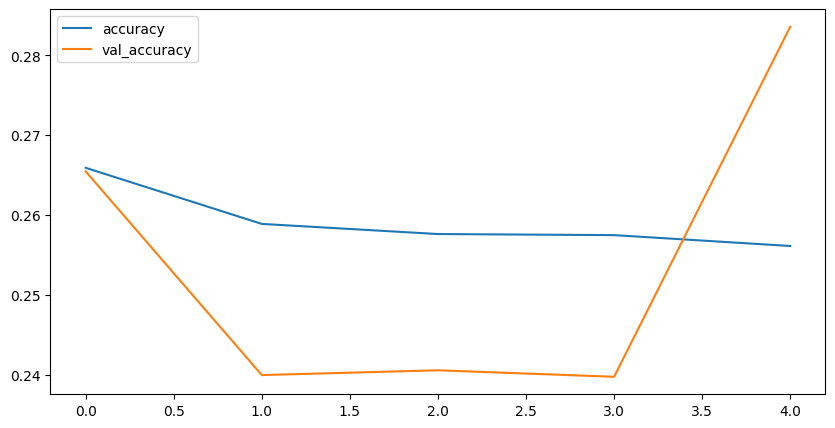

In [12]:
# Plot accuracy
plt.figure(figsize=(10, 5))
plt.plot(results.history['accuracy'], label='accuracy')
plt.plot(results.history['val_accuracy'], label='val_accuracy')
plt.legend()
plt.show()

In [12]:
# Load checkpoint in folder './learning3'
model.load_weights(tf.train.latest_checkpoint('./learning3'))

1/1 [==============================] - 5s 5s/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


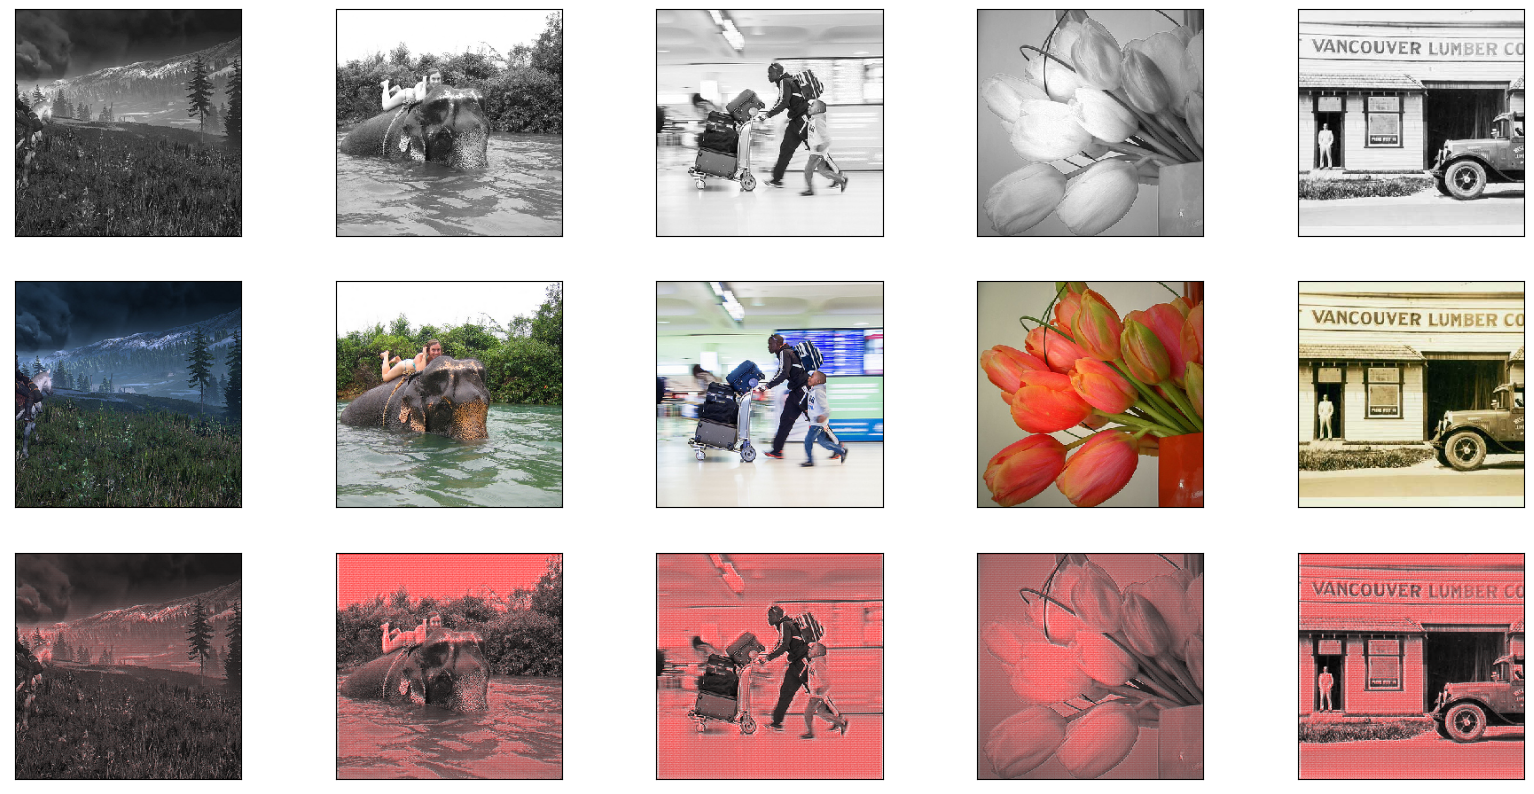

In [10]:
# Predict on a batch of 32 test images and plot the results

batch = test_ds[3]

# batch[0][i] is a (256, 256, 1) V channel image (input)
# batch[1][i] is a (256, 256, 3) HSV image

# Predict
pred = model.predict(batch[0])

# Plot 5 images in (3, 5) grid
# In the first row, plot the input image
# In the second row, plot the ground truth
# In the third row, plot the predicted image
# Remember to convert the predicted and ground truth images from HSV to RGB

fig, axes = plt.subplots(3, 5, figsize=(20, 10))
for i in range(5):
    axes[0, i].imshow(batch[0][i, ..., 0], cmap='gray')
    axes[1, i].imshow(tf.image.hsv_to_rgb(batch[1][i]))
    axes[2, i].imshow(tf.image.hsv_to_rgb(pred[i]))

for ax in axes.flatten():
    ax.set_xticks([])
    ax.set_yticks([])
plt.show()


# Show results

In [18]:
%tensorboard --logdir logs/fit

Launching TensorBoard...

In [ ]:
#show graphs

# Save modif of files

In [ ]:
!git config --global credential.helper store
!git config --global credential.helper 'cache --timeout 7200'

In [ ]:
!git remote set-url origin git@github.com:Dario-CP/comp4471_final_project.git

In [ ]:
!git remote -v

In [ ]:
!git add ./U_net.ipynb
!git commit -m "auto modif U_net"
!git push git@github.com:Dario-CP/comp4471_final_project.git

# Show results

In [55]:
%tensorboard --logdir logs/fit

<IPython.core.display.Javascript object>

In [ ]:
#show graphs

# Save modif of files

In [3]:
!git config --global credential.helper store
!git config --global credential.helper 'cache --timeout 7200'

error: cannot overwrite multiple values with a single value
       Use a regexp, --add or --replace-all to change credential.helper.
error: cannot overwrite multiple values with a single value
       Use a regexp, --add or --replace-all to change credential.helper.


In [7]:
!git remote set-url origin git@github.com:Dario-CP/comp4471_final_project.git

In [5]:
!git remote -v

origin	git@github.com/Dario-CP/comp4471_final_project.git (fetch)
origin	git@github.com/Dario-CP/comp4471_final_project.git (push)


In [8]:
!git add ./U_net.ipynb
!git commit -m "auto modif U_net"
!git push git@github.com:Dario-CP/comp4471_final_project.git

[main 21db6af] auto modif U_net
 1 file changed, 1 insertion(+), 1 deletion(-)
Host key verification failed.
fatal: Could not read from remote repository.

Please make sure you have the correct access rights
and the repository exists.
